## 📊 Tehran Rent Market Analysis (1403) – Clustering
## Objective
The goal of this notebook is to cluster Tehran rental ads based on specific features to better understand the processes and trends in the market.

## Focus Areas
- Find the optimal number of clusters

- Define key features for clustering

- Calculate seasonal growth for each cluster

- Uncover the story and characteristics of each cluster

- Visualize clusters on a map

## Input
Cleaned CSV file of rental listings (from the first phase)

## Output
A clustering map and a dashboard with key results (created in Power BI)

## Tools & Libraries
- Python

- Pandas

- NumPy

In [9]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re

In [10]:
source_file=pd.read_csv(r"..\data\cleaned_data.csv",encoding='utf-8',low_memory=False)

## Find the optimal number of clusters

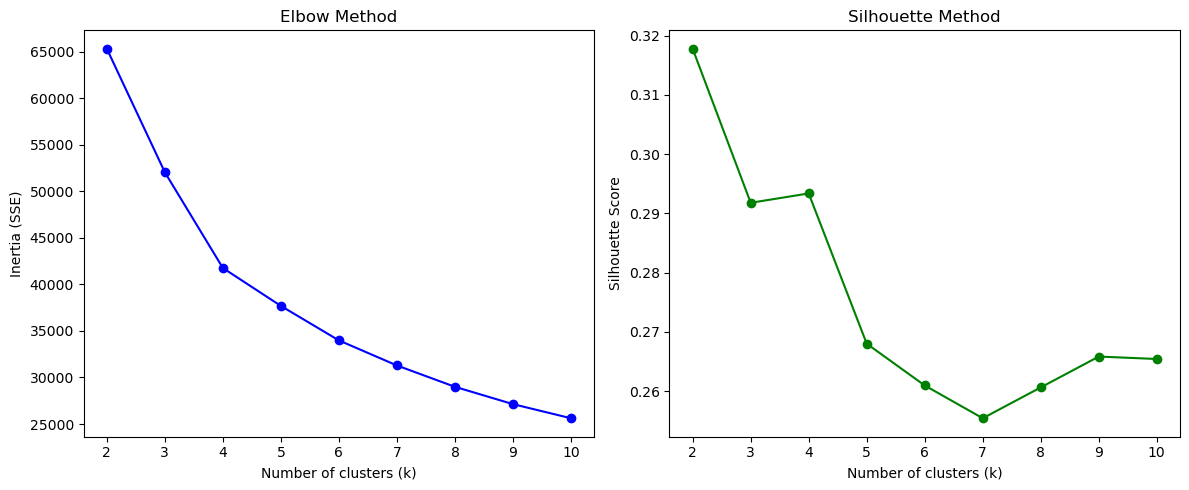

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = source_file[["location_latitude", "location_longitude", "total_cost","building_size"]]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


k_range = range(2, 11)
inertia = []
silhouette = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# رسم Elbow
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')

# رسم Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()


## Methods Output
Both methods suggest that 4 clusters are appropriate

## Preparing Data and Performing Clustering

In [12]:
neighborhood_costs=source_file.groupby("neighborhood_slug").agg({ "location_latitude": "median",
    "location_longitude": "median","title":"count",
    "total_cost": "median","building_size":"median","cost_per_sqm":"median"  # یا "mean" بسته به تحلیلت
}).reset_index()

In [13]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

x = neighborhood_costs[["location_latitude", "location_longitude","title", "total_cost","building_size"]].copy()

# نرمال‌سازی ویژگی‌ها
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
w_loc = 1.2# کمی افزایش وزن مختصات
w_cost = 1
x_scaled[:,0]*= w_loc
x_scaled[:,1]*= w_loc
x_scaled[:,2]*= w_cost

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
neighborhood_costs["cluster"] = kmeans.fit_predict(x_scaled)

In [16]:
source_file=source_file.merge(neighborhood_costs[["neighborhood_slug","cluster"]],on="neighborhood_slug",how="left")

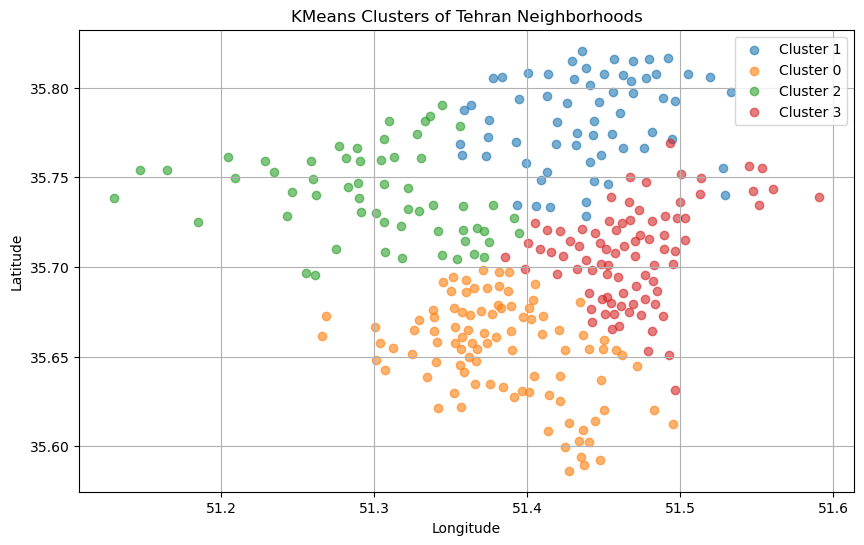

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for cluster in neighborhood_costs["cluster"].unique():
    subset = neighborhood_costs[neighborhood_costs["cluster"] == cluster]
    plt.scatter(subset["location_longitude"], subset["location_latitude"], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters of Tehran Neighborhoods")
plt.legend()
plt.grid(True)
plt.show()

## Calculate seasonal growth for each cluster

In [18]:
cluster_season_costs = (
    source_file
    .groupby(["cluster","season"])
    .agg(mean_cost=("total_cost", "mean"))
    .reset_index()
)

In [19]:
season_order = ["spring", "summer", "autumn", "winter"]

In [20]:
cluster_season_costs["season"]=pd.Categorical(cluster_season_costs["season"],season_order,ordered=True)
cluster_season_costs=cluster_season_costs.sort_values(["cluster", "season"])

In [21]:
cluster_season_costs["season_growth"] = (
    cluster_season_costs
    .groupby("cluster")["mean_cost"]
    .pct_change()
)

In [22]:
cluster_growth_stats = (
    cluster_season_costs
    .groupby("cluster")
    .agg(total_season_growth=("mean_cost",lambda x:(x.iloc[-1]-x.iloc[0]/x.iloc[0])),std_growth=("season_growth",lambda x:np.std(x.dropna()))).reset_index())

In [23]:
cluster_growth_stats["composite_season_growth_index"] = cluster_growth_stats["total_season_growth"] / (cluster_growth_stats["std_growth"] + 1e-6)

## Uncover the story and characteristics of each cluster


| خوشه | ناحیه تهران | شاخص مرکب رشد (`composite index`) | تفسیر عملکرد                                                              |
| ---- | ----------- | --------------------------------- | ------------------------------------------------------------------------- |
| 2    | غرب         | **792.6 میلیون**                  | 📈 **رشد پایدار، نوسان پایین**؛ مناسب برای سرمایه‌گذاری میان‌مدت          |
| 1    | شمال        | 559.4 میلیون                      | 💰 رشد بالا، اما با نوسان؛ مناطق لوکس با رفتار خاص بازار                  |
| 3    | مرکز + شرق  | 152.3 میلیون                      | ⚠️ نوسان بالا، رشد نامنظم؛ رفتار قیمتی متغیر (ممکن است فرصت یا ریسک باشد) |
| 0    | جنوب        | 198.8 میلیون                      | 🔻 رشد کم و نوسان متوسط؛ بازار نسبتاً ایستا، احتمالا کم‌تقاضا یا اشباع    |



In [24]:
source_file=source_file.merge(cluster_growth_stats[["cluster","total_season_growth","std_growth","composite_season_growth_index"]],on="cluster",how="left")

## Visualize clusters on a map

In [25]:
show_cluster=source_file.groupby("neighborhood_slug").agg({"location_latitude": "median",
    "location_longitude": "median","cluster":"first","composite_season_growth_index":"first"}).reset_index()

In [26]:
import folium
from folium import plugins
m = folium.Map(location=[35.6892, 51.3890], zoom_start=11)

# مرحله 3: تعریف رنگ برای هر خوشه
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange'
}

# مرحله 4: افزودن نقاط روی نقشه
for _, row in show_cluster.iterrows():
    folium.CircleMarker(
        location=[row['location_latitude'], row['location_longitude']],
        radius=6,
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['neighborhood_slug']}\nGrowth Index: {row['composite_season_growth_index']:.2e}"
    ).add_to(m)

# مرحله 5: ذخیره یا نمایش نقشه
m.save("tehran_clusters_map.html")